# Setup

In [1]:
# !nvidia-smi -L

In [2]:
# import plotly.io as pio
# try:
#     import google.colab
#     print("Running as a Colab notebook")
#     pio.renderers.default = "colab"
#     %pip install transformer-lens fancy-einsum
#     %pip install -U kaleido # kaleido only works if you restart the runtime. Required to write figures to disk (final cell)
# except:
#     print("Running as a Jupyter notebook")
#     pio.renderers.default = "vscode"
#     from IPython import get_ipython
#     ipython = get_ipython()

In [3]:
# !pip install 'torchtyping'

In [4]:
# import torch
# from fancy_einsum import einsum
# from transformer_lens import HookedTransformer, HookedTransformerConfig, utils, ActivationCache
# from torchtyping import TensorType as TT
# import plotly.express as px
# import plotly.graph_objects as go
# import numpy as np
# import einops
# from typing import List, Union, Optional
# from functools import partial
# import pandas as pd
# from pathlib import Path
# import urllib.request
# from bs4 import BeautifulSoup
# from tqdm import tqdm
# from datasets import load_dataset
# import os
# os.environ["TOKENIZERS_PARALLELISM"] = "false" # https://stackoverflow.com/q/62691279
# torch.set_grad_enabled(False)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device

In [5]:
# model = HookedTransformer.from_pretrained(
#     "gpt2-small",
#     center_unembed=True,
#     center_writing_weights=True,
#     fold_ln=True,
#     refactor_factored_attn_matrices=True,
#     device=device,
# )

In [6]:
%%capture
%pip install git+https://github.com/redwoodresearch/Easy-Transformer.git
%pip install einops datasets transformers fancy_einsum

In [7]:
from copy import deepcopy
import torch

# assert torch.cuda.device_count() == 1
from tqdm import tqdm
import pandas as pd
import torch
import torch as t
from easy_transformer.EasyTransformer import (
    EasyTransformer,
)
from time import ctime
from functools import partial

import numpy as np
from tqdm import tqdm
import pandas as pd

from easy_transformer.experiments import (
    ExperimentMetric,
    AblationConfig,
    EasyAblation,
    EasyPatching,
    PatchingConfig,
)
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import random
import einops
from IPython import get_ipython
from copy import deepcopy
from easy_transformer.ioi_dataset import (
    IOIDataset,
)
from easy_transformer.ioi_utils import (
    path_patching,
    max_2d,
    CLASS_COLORS,
    show_pp,
    show_attention_patterns,
    scatter_attention_and_contribution,
)
from random import randint as ri
from easy_transformer.ioi_circuit_extraction import (
    do_circuit_extraction,
    get_heads_circuit,
    CIRCUIT,
)
from easy_transformer.ioi_utils import logit_diff, probs
from easy_transformer.ioi_utils import get_top_tokens_and_probs as g

ipython = get_ipython()
if ipython is not None:
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

In [8]:
# model = EasyTransformer.from_pretrained("gpt2").cuda()
model = EasyTransformer.from_pretrained("gpt2")
model.set_use_attn_result(True)

/usr/local/lib/python3.10/dist-packages/easy_transformer/components.py:616: UserWarning: Moved LN1 to the attention block
  warnings.warn("Moved LN1 to the attention block")


Moving model to device:  cpu
Finished loading pretrained model gpt2 into EasyTransformer!


# Dot products of tokens after embedding layer

In [ ]:
def dotprod_tokens(token_1, token_2):
    token_1_idx = model.to_single_token(token_1)
    token_2_idx = model.to_single_token(token_2)

    token_1_embedding = model.embed.W_E[token_1_idx]
    token_2_embedding = model.embed.W_E[token_2_idx]

    return torch.dot(token_1_embedding, token_2_embedding)

In [ ]:
token_1_idx = model.to_single_token(" large")
token_1_embedding = model.embed.W_E[token_1_idx]
token_1_embedding.shape

torch.Size([768])

In [ ]:
model.embed.W_E.shape

torch.Size([50257, 768])

Embedding is vocab size x d_model = 50257 x 768. So for one token, it's 1 x 768.

## large

In [ ]:
dotprod_tokens(" large", " huge")

tensor(5.7984, grad_fn=<DotBackward0>)

In [ ]:
dotprod_tokens("large", "huge")

tensor(8.0984, grad_fn=<DotBackward0>)

In [ ]:
dotprod_tokens("large", "small")

tensor(9.6101, grad_fn=<DotBackward0>)

In [ ]:
dotprod_tokens("large", "red")

tensor(3.6921, grad_fn=<DotBackward0>)

In [ ]:
dotprod_tokens(" large", " red")

tensor(2.6266, grad_fn=<DotBackward0>)

In [ ]:
dotprod_tokens(" large", "large")

tensor(6.6153, grad_fn=<DotBackward0>)

In [ ]:
dotprod_tokens(" large", " large")

tensor(8.1915, grad_fn=<DotBackward0>)

In [ ]:
dotprod_tokens("large", "large")

tensor(16.0763, grad_fn=<DotBackward0>)

Without spaces in front gives higher dot product

In [ ]:
dotprod_tokens("large", "concept")

tensor(4.2746, grad_fn=<DotBackward0>)

In [ ]:
dotprod_tokens("large", "wine")

tensor(5.5509, grad_fn=<DotBackward0>)

In [ ]:
dotprod_tokens("large", "horse")

tensor(4.0996, grad_fn=<DotBackward0>)

In [ ]:
dotprod_tokens("large", "food")

tensor(5.0110, grad_fn=<DotBackward0>)

In [ ]:
dotprod_tokens("large", "sleep")

tensor(4.5059, grad_fn=<DotBackward0>)

In [ ]:
dotprod_tokens("large", "tall")

tensor(6.9034, grad_fn=<DotBackward0>)

## tokens in general

In [ ]:
dotprod_tokens("bird", "tall")

tensor(4.6381, grad_fn=<DotBackward0>)

In [ ]:
dotprod_tokens("bird", "concept")

tensor(5.7684, grad_fn=<DotBackward0>)

## average over dataset of single tokens

In [ ]:
import random
import nltk

def generate_random_tokens(num_words):
    # Download the CMU Pronouncing Dictionary if not already downloaded
    nltk.download('cmudict')

    # Load the CMU Pronouncing Dictionary
    cmudict = nltk.corpus.cmudict.dict()

    rand_tokens = []
    while len(rand_tokens) < num_words:
        word = random.choice(list(cmudict.keys()))
        try:
            token = model.to_single_token(word)
            rand_tokens.append(word.lower())
        except:
            continue

        # If all available one-syllable words have been exhausted
        if len(rand_tokens) == len(cmudict.keys()):
            print("Warning: Insufficient one-syllable words in the CMU Pronouncing Dictionary.")
            break

    return rand_tokens

num_words = 100
rand_tokens = generate_random_tokens(num_words)

# Print the generated words
for word in rand_tokens[:10]:
    print(word)

[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


event
adapt
inventory
hack
energy
fields
erion
host
oba
gat


In [ ]:
def compute_average_dot_product(tokens, model):
    num_tokens = len(tokens)
    dot_product_sum = 0
    num_pairs = 0
    for i in range(num_tokens):
        for j in range(i + 1, num_tokens):
            dot_product = dotprod_tokens(tokens[i], tokens[j])
            dot_product_sum += dot_product
            num_pairs += 1
    average_dot_product = dot_product_sum / num_pairs
    return average_dot_product

# Compute the average dot product
average_dot_product = compute_average_dot_product(rand_tokens, model)
print(average_dot_product)

tensor(4.9035, grad_fn=<DivBackward0>)


In [ ]:
import matplotlib.pyplot as plt

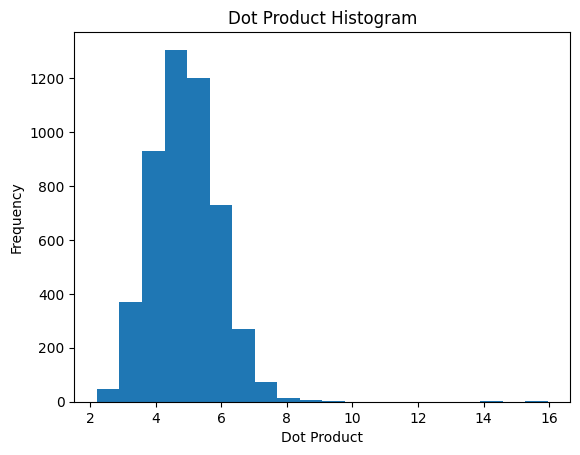

In [ ]:
dot_products = []
for i in range(len(rand_tokens)):
    for j in range(i + 1, len(rand_tokens)):
        dot_product = dotprod_tokens(rand_tokens[i], rand_tokens[j])
        dot_products.append(dot_product.item())

plt.hist(dot_products, bins=20)
plt.xlabel('Dot Product')
plt.ylabel('Frequency')
plt.title('Dot Product Histogram')
plt.show()

## For multiple tokens for a word, get the average of each token's embeddings

In [ ]:
model.to_tokens("enormous")

tensor([[50256,   268,   579,   516]])

In [ ]:
embeddings = model.embed.W_E[model.to_tokens("enormous")]
embeddings.shape

torch.Size([1, 4, 768])

In [ ]:
mean_emb = torch.mean(model.embed.W_E[model.to_tokens("enormous")], dim=1)
mean_emb.shape

torch.Size([1, 768])

In [ ]:
mean_emb[0].shape

torch.Size([768])

In [ ]:
def generate_random_tokens(num_words):
    # Download the CMU Pronouncing Dictionary if not already downloaded
    nltk.download('cmudict')
    # Load the CMU Pronouncing Dictionary
    cmudict = nltk.corpus.cmudict.dict()
    rand_tokens = []
    while len(rand_tokens) < num_words:
        word = random.choice(list(cmudict.keys()))
        rand_tokens.append(word)
    return rand_tokens

num_words = 100
rand_tokens = generate_random_tokens(num_words)

# Print the generated words
for word in rand_tokens:
    print(word)

In [ ]:
def compute_dot_product(token_1, token_2, model):
    token_1_embedding = torch.mean(model.embed.W_E[model.to_tokens(token_1)], dim=1)[0]
    token_2_embedding = torch.mean(model.embed.W_E[model.to_tokens(token_2)], dim=1)[0]
    dot_product = torch.dot(token_1_embedding, token_2_embedding)
    return dot_product

In [ ]:
def compute_average_dot_product(tokens, model):
    num_tokens = len(tokens)
    dot_product_sum = 0
    num_pairs = 0
    for i in range(num_tokens):
        for j in range(i + 1, num_tokens):
            dot_product = compute_dot_product(tokens[i], tokens[j], model)
            dot_product_sum += dot_product
            num_pairs += 1
    average_dot_product = dot_product_sum / num_pairs
    return average_dot_product

# Compute the average dot product
average_dot_product = compute_average_dot_product(rand_tokens, model)
print(average_dot_product)

tensor(3.7588, grad_fn=<DivBackward0>)


## Dot Product of large synonyms

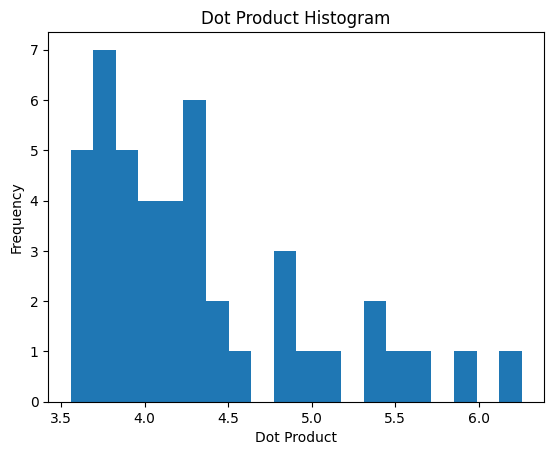

In [ ]:
synonyms_large = ["big", "huge", "enormous", "massive", "gigantic", "immense", "vast", "substantial", "grand", "colossal"]


dot_products = []
for i in range(len(synonyms_large)):
    for j in range(i + 1, len(synonyms_large)):
        dot_product = compute_dot_product(synonyms_large[i], synonyms_large[j], model)
        dot_products.append(dot_product.item())

# Generate histogram of dot products
plt.hist(dot_products, bins=20)
plt.xlabel('Dot Product')
plt.ylabel('Frequency')
plt.title('Dot Product Histogram')
plt.show()


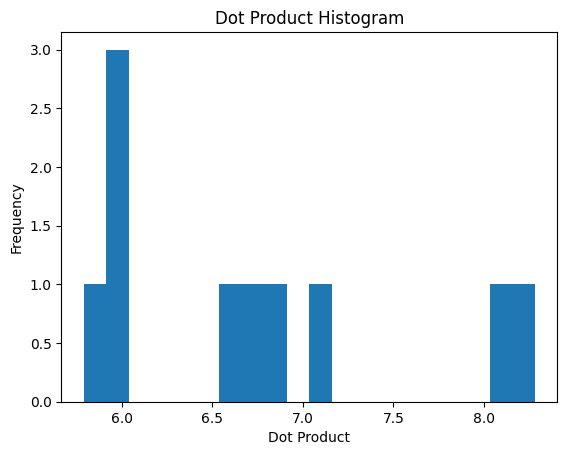

In [ ]:
# Try one syllable only

synonyms_large = ["large", "big", "huge", "grand", "tall"]

dot_products = []
for i in range(len(synonyms_large)):
    for j in range(i + 1, len(synonyms_large)):
        # dot_product = compute_dot_product(synonyms_large[i], synonyms_large[j], model)
        dot_product = dotprod_tokens(synonyms_large[i], synonyms_large[j])

        dot_products.append(dot_product.item())

# Generate histogram of dot products
plt.hist(dot_products, bins=20)
plt.xlabel('Dot Product')
plt.ylabel('Frequency')
plt.title('Dot Product Histogram')
plt.show()

In [ ]:
dot_products = []
for i in range(len(synonyms_large)):
    for j in range(i + 1, len(synonyms_large)):
        dot_product = dotprod_tokens(synonyms_large[i], synonyms_large[j])
        dot_products.append((dot_product.item(), synonyms_large[i], synonyms_large[j]))

dot_products

[(6.642685890197754, 'large', 'big'),
 (8.09839153289795, 'large', 'huge'),
 (5.789479732513428, 'large', 'grand'),
 (6.903449058532715, 'large', 'tall'),
 (8.280406951904297, 'big', 'huge'),
 (5.954333305358887, 'big', 'grand'),
 (6.769491672515869, 'big', 'tall'),
 (5.948497772216797, 'huge', 'grand'),
 (7.088854789733887, 'huge', 'tall'),
 (5.942311763763428, 'grand', 'tall')]

# Dot products of token and all neurons (congruence)

We define congruence as this dot product

In [ ]:
tokens_of_interest_strs = ["large"]
tokens_of_interest = torch.tensor([model.to_single_token(token_str) for token_str in tokens_of_interest_strs])
tokens_of_interest[0]

tensor(11664)

In [ ]:
def get_congr_token_noplot(token):
    tokens_of_interest_strs = [token]
    tokens_of_interest = torch.tensor([model.to_single_token(token_str) for token_str in tokens_of_interest_strs])

    mlp_output_weights = torch.cat([block.mlp.W_out for block in model.blocks], dim=0)# (n_layer * d_mlp, d_model)

    token_of_interest_dot_product = torch.einsum("d, nd -> n", model.embed.W_E[tokens_of_interest[0]], mlp_output_weights)
    return token_of_interest_dot_product

In [ ]:
get_congr_token_noplot("large")

tensor([-0.5676,  0.2627, -0.1835,  ...,  0.1700, -0.3451, -1.8755],
       grad_fn=<ViewBackward0>)

In [ ]:
dot_product_large = get_congr_token_noplot("large")
dot_product_tall = get_congr_token_noplot("tall")

# Calculate the dot product between the two outputs' congruence (congruence similarity)
dot_product_of_outputs = torch.dot(dot_product_large, dot_product_tall)
print(dot_product_of_outputs)

tensor(9334.0410, grad_fn=<DotBackward0>)


In [ ]:
dot_product_large = get_congr_token_noplot("large")
dot_product_tall = get_congr_token_noplot("big")

# Calculate the dot product between the two outputs
dot_product_of_outputs = torch.dot(dot_product_large, dot_product_tall)
print(dot_product_of_outputs)

tensor(7067.6182, grad_fn=<DotBackward0>)


In [ ]:
dot_product_large = get_congr_token_noplot("large")
dot_product_tall = get_congr_token_noplot("red")

# Calculate the dot product between the two outputs
dot_product_of_outputs = torch.dot(dot_product_large, dot_product_tall)
print(dot_product_of_outputs)

tensor(3431.4565, grad_fn=<DotBackward0>)


In [ ]:
dot_product_large = get_congr_token_noplot("red")
dot_product_tall = get_congr_token_noplot("horse")

# Calculate the dot product between the two outputs
dot_product_of_outputs = torch.dot(dot_product_large, dot_product_tall)
print(dot_product_of_outputs)

tensor(3385.9529, grad_fn=<DotBackward0>)


Next, run get_congr_token_noplot() on random words (single tokens) and get the histogram

In [ ]:
def generate_random_tokens(num_words):
    # Download the CMU Pronouncing Dictionary if not already downloaded
    nltk.download('cmudict')

    # Load the CMU Pronouncing Dictionary
    cmudict = nltk.corpus.cmudict.dict()

    rand_tokens = []
    while len(rand_tokens) < num_words:
        word = random.choice(list(cmudict.keys()))
        try:
            token = model.to_single_token(word)
            rand_tokens.append(word.lower())
        except:
            continue

        # If all available one-syllable words have been exhausted
        if len(rand_tokens) == len(cmudict.keys()):
            print("Warning: Insufficient one-syllable words in the CMU Pronouncing Dictionary.")
            break

    return rand_tokens

num_words = 100
rand_tokens = generate_random_tokens(num_words)

[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


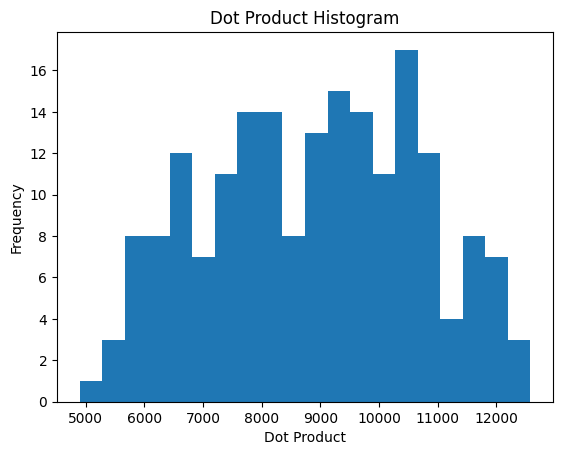

In [ ]:
dot_products = []
for i in range(len(rand_tokens[0:20])):
    for j in range(i + 1, len(rand_tokens[0:20])):
        dot_product = torch.dot(get_congr_token_noplot(rand_tokens[i]), get_congr_token_noplot(rand_tokens[j]))
        dot_products.append(dot_product.item())
    print(i)

plt.hist(dot_products, bins=20)
plt.xlabel('Dot Product')
plt.ylabel('Frequency')
plt.title('Dot Product Histogram')
plt.show()

This plot gets the dot product of all pairs of N*T, where N is the matrix of all neurons (rows) and their output weights (cols).

We see that the dot product of large and tall for all neurons (after passing through the entire model, basically) is higher with each other than the typical average. This shows that the neurons typically find some "similarity" between the two tokens.

If we isolate the neurons with the biggest impact, and only take the dot prod of tokens with those neurons, this similarity is prob even bigger.

### Compute dot products for "tall" and "large", and compare the similarities (eg. which are in the top) AND identify their common top neurons

In [ ]:
def get_congr_token(token):
    tokens_of_interest_strs = [token]
    tokens_of_interest = torch.tensor([model.to_single_token(token_str) for token_str in tokens_of_interest_strs])

    mlp_output_weights = torch.cat([block.mlp.W_out for block in model.blocks], dim=0)# (n_layer * d_mlp, d_model)

    congruence_list = []

    for i, token_of_interest_str in enumerate(tokens_of_interest_strs[:1]):
        token_of_interest_dot_product = torch.einsum("d, nd -> n", model.embed.W_E[tokens_of_interest[i]], mlp_output_weights)
        for j in range(mlp_output_weights.shape[0]):
            layer_index = j // model.cfg.d_mlp
            neuron_index = j % model.cfg.d_mlp
            dot_product = token_of_interest_dot_product[j].item()
            congruence_list.append((layer_index, neuron_index, dot_product))

    # Sorting the list based on the dot product value in descending order
    congruence_list.sort(key=lambda x: x[2], reverse=True)

    return congruence_list

# Call the function and print the top 10 results
congruence_list = get_congr_token("large")
for layer, neuron, dot_product in congruence_list[:10]:
    print(f"Layer: {layer}, Neuron: {neuron}, Dot product: {dot_product}")


Layer: 11, Neuron: 3033, Dot product: 10.153202056884766
Layer: 11, Neuron: 584, Dot product: 6.391915798187256
Layer: 11, Neuron: 2123, Dot product: 6.043896675109863
Layer: 11, Neuron: 2888, Dot product: 6.002010345458984
Layer: 11, Neuron: 1941, Dot product: 4.2660627365112305
Layer: 11, Neuron: 2361, Dot product: 4.212543487548828
Layer: 11, Neuron: 1186, Dot product: 4.054311275482178
Layer: 11, Neuron: 483, Dot product: 4.016766548156738
Layer: 11, Neuron: 2727, Dot product: 3.95424747467041
Layer: 10, Neuron: 2193, Dot product: 3.7432491779327393


In [ ]:
# Call the function and print the top 10 results
congruence_list = get_congr_token("tall")
for layer, neuron, dot_product in congruence_list[:10]:
    print(f"Layer: {layer}, Neuron: {neuron}, Dot product: {dot_product}")

Layer: 11, Neuron: 3033, Dot product: 15.378734588623047
Layer: 11, Neuron: 584, Dot product: 9.504816055297852
Layer: 11, Neuron: 2123, Dot product: 8.900127410888672
Layer: 11, Neuron: 2888, Dot product: 7.337953567504883
Layer: 11, Neuron: 2727, Dot product: 6.2406721115112305
Layer: 11, Neuron: 2361, Dot product: 6.2252912521362305
Layer: 11, Neuron: 2460, Dot product: 5.3092041015625
Layer: 11, Neuron: 2604, Dot product: 5.289836883544922
Layer: 11, Neuron: 1245, Dot product: 4.909438133239746
Layer: 11, Neuron: 1941, Dot product: 4.526031494140625


In [ ]:
# Call the function and print the top 10 results
congruence_list = get_congr_token("red")
for layer, neuron, dot_product in congruence_list[:10]:
    print(f"Layer: {layer}, Neuron: {neuron}, Dot product: {dot_product}")

Layer: 11, Neuron: 2604, Dot product: 5.678971290588379
Layer: 11, Neuron: 2227, Dot product: 4.7803850173950195
Layer: 10, Neuron: 1971, Dot product: 4.700037956237793
Layer: 11, Neuron: 2377, Dot product: 4.389562606811523
Layer: 10, Neuron: 609, Dot product: 4.308917999267578
Layer: 11, Neuron: 3033, Dot product: 3.4321320056915283
Layer: 11, Neuron: 553, Dot product: 3.3559627532958984
Layer: 11, Neuron: 1577, Dot product: 3.2768287658691406
Layer: 10, Neuron: 693, Dot product: 3.2118849754333496
Layer: 10, Neuron: 571, Dot product: 3.1271438598632812


# Dot products of input after first MLP layer

In [ ]:
def get_logits(input_text, model):
    input_tokens = model.tokenizer.encode(input_text, add_special_tokens=True)
    input_tensor = torch.tensor(input_tokens).unsqueeze(0)  # Adding batch dimension
    outputs = model(input_tensor)
    return outputs

input_text = "large"
intermediate_embeddings = get_logits(input_text, model)
print(intermediate_embeddings.shape)

torch.Size([1, 1, 50257])


In [ ]:
input_text = "huge"
intermediate_embeddings_2 = get_logits(input_text, model)
print(intermediate_embeddings_2)

tensor([[[ 5.0742,  6.2680,  2.9993,  ..., -0.7970, -1.2818,  4.6927]]],
       grad_fn=<AddBackward0>)


In [ ]:
torch.dot(intermediate_embeddings, intermediate_embeddings_2)

RuntimeError: ignored

In [ ]:
# Assuming intermediate_embeddings and intermediate_embeddings_2 are 3D tensors
# with shapes (batch_size, sequence_length, embedding_size)

# Compute the dot product along the last dimension (embedding_size)
dot_product = torch.matmul(intermediate_embeddings, intermediate_embeddings_2.transpose(1, 2))
dot_product

tensor([[[81807.3594]]], grad_fn=<UnsafeViewBackward0>)

Below requires setup code from "IOI notebook", not "an neuron notebook"

In [ ]:
def get_interm_embed(tokens, model):
    input_tokens = model.tokenizer.encode(input_text, add_special_tokens=True)
    input_tensor = torch.tensor(input_tokens).unsqueeze(0)  # Adding batch dimension

    cache = {}  # Create a dictionary to store intermediate outputs
    model.cache_some(cache, lambda x: x == "blocks.0.hook_resid_post") #  Hook into the desired layer to capture intermediate output
    model(tokens)
    intermediate_embeddings = model.blocks[1].attn.ln1(cache["blocks.0.hook_resid_post"])

    return intermediate_embeddings

In [ ]:
input_text = "large"
intermediate_embeddings = get_interm_embed(input_text, model)
input_text = "huge"
intermediate_embeddings_2 = get_interm_embed(input_text, model)

dot_product = torch.matmul(intermediate_embeddings, intermediate_embeddings_2.transpose(1, 2))
dot_product

tensor([[[768.0000, 182.4072],
         [164.7558, 647.2665]]])

In [ ]:
torch.dot(intermediate_embeddings, intermediate_embeddings_2)

RuntimeError: ignored

In [ ]:
intermediate_embeddings.shape

torch.Size([1, 2, 768])

Why output after 1st embed gets scalar, this isn't?